# 1/ Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For Preprocesssing Text Data
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualizing Wordcloud
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the train test split
from sklearn.model_selection import train_test_split

# Check Performance
from sklearn.metrics import classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/ipba-17-nlp-with-disaster-tweets-2024/sample_submission.csv
/kaggle/input/ipba-17-nlp-with-disaster-tweets-2024/train.csv
/kaggle/input/ipba-17-nlp-with-disaster-tweets-2024/test.csv


# 2/ Import Data

In [2]:
train = pd.read_csv('/kaggle/input/ipba-17-nlp-with-disaster-tweets-2024/train.csv')


# 3/Data Exploration

In [3]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.sample(5,random_state=42)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
train.shape

(7613, 5)

In [6]:
#check column names
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# 4/ Check Target Feature

In [8]:
#check target feature
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

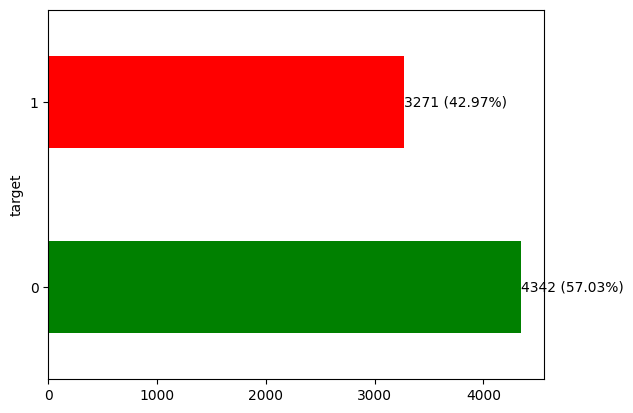

In [9]:
import matplotlib.pyplot as plt

# Calculate value counts and percentages
value_counts = train['target'].value_counts()
total_samples = len(train['target'])
percentages = (value_counts / total_samples) * 100

# Plot horizontal bar plot
ax = value_counts.plot.barh(color=['red' if idx == 1 else 'green' for idx in value_counts.index])

# Annotate bars with counts and percentages
for i, (count, percent) in enumerate(zip(value_counts, percentages)):
    ax.text(count, i, f'{count} ({percent:.2f}%)', color='black', va='center')

plt.show()


# 5/ Distributon of Target in Top key words

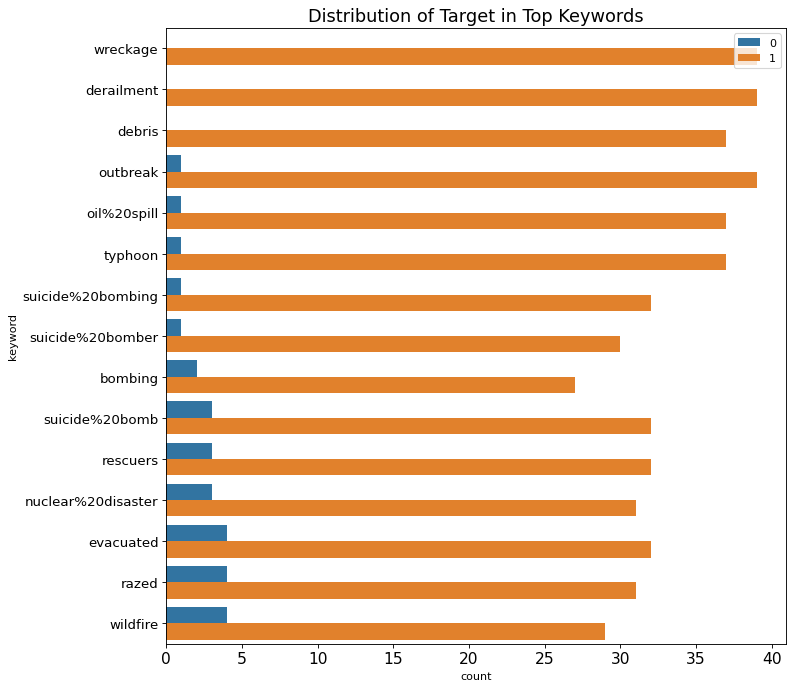

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the mean target value for each keyword
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

# Select the top N keywords based on their mean target value
top_keywords = train.groupby('keyword')['target_mean'].mean().nlargest(15).index

# Filter the DataFrame to only include the top N keywords
top_train = train[train['keyword'].isin(top_keywords)]

# Create a figure with customized size and DPI
fig = plt.figure(figsize=(10, 10), dpi=80)

# Plot the count of keywords sorted by mean target value, with target as hue
sns.countplot(y=top_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=top_train.sort_values(by='target_mean', ascending=False)['target'])

# Customize tick label sizes
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=12)

# Place legend at a specific location (loc=1: upper right)
plt.legend(loc=1)

# Add a title to the plot
plt.title('Distribution of Target in Top Keywords', fontsize=16)

# Show the plot
plt.show()

# Remove the temporary column 'target_mean'
train.drop(columns=['target_mean'], inplace=True)


# 6/Missing value treatment

In [11]:
#checking missing values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
#replacing missing location values with unknown
train['location'] = train['location'].fillna('unknown')
train['keyword'] = train['keyword'].fillna('unknown')

In [13]:
#checking missing values
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

# 7/ After Missing value treatment Data Exploration

In [14]:
train.head()

,id,keyword,location,text,target
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
#number of unique values in location
train['location'].nunique()

3342

In [16]:
#number of unique values in location
train['location'].value_counts()

location
unknown                         2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

In [17]:
#number of unique values in keyword
train['keyword'].nunique()

222

In [18]:
#number of unique values in keyword
train['keyword'].value_counts()

keyword
unknown                  61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

# 8/ Distribution of Text Length

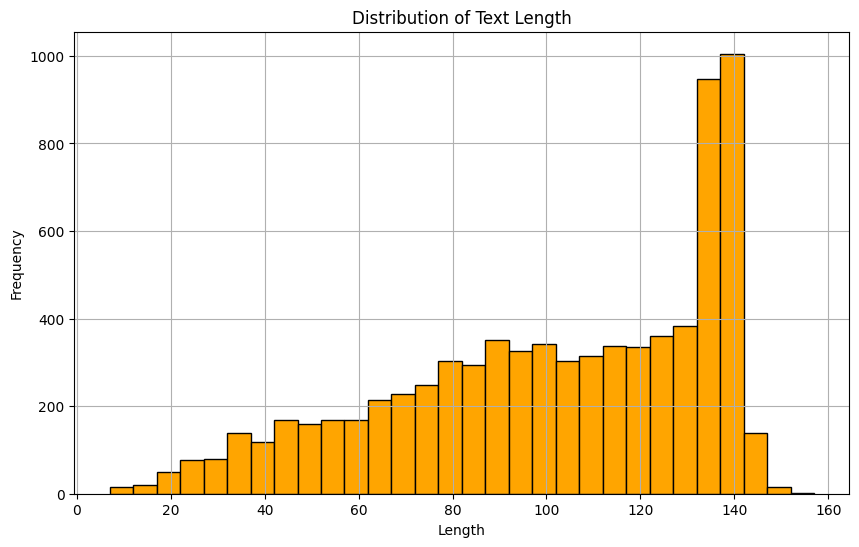

In [19]:
import matplotlib.pyplot as plt

# Compute the length of each text
train['length'] = train['text'].apply(len)

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.hist(train['length'], bins=30, color='#FFA500', edgecolor='black')  # Adjust the color and edgecolor
plt.xlabel('Length')  # Label for x-axis
plt.ylabel('Frequency')    # Label for y-axis
plt.title('Distribution of Text Length')  # Title for the plot
plt.grid(True)  # Add gridlines for better readability
plt.show()


In [20]:
train.head()

,id,keyword,location,text,target,length
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,38
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1,133
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,65
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,88


In [21]:
!pip install wordcloud


# 9/ Generating word cloud for target 1

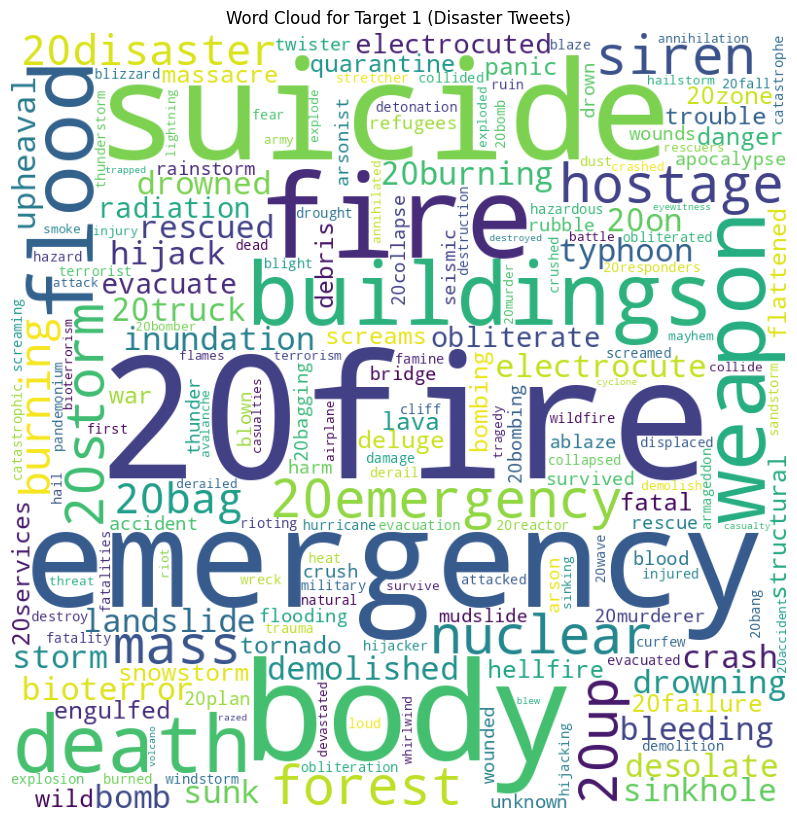

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for tweets with target value 1 (disaster)
disaster_tweets = train[train['target'] == 1]

# Remove duplicate keywords and generate word cloud for target 1
wordcloud_target_1 = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(set(disaster_tweets['keyword'].dropna())))

# Plot word cloud for target 1
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_target_1)
plt.title('Word Cloud for Target 1 (Disaster Tweets)')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [23]:
# Filter the DataFrame for tweets with target value 1 (disaster)
disaster_tweets = train[train['target'] == 1]

# Count unique keywords for target 1
keyword_counts_target_1 = disaster_tweets['keyword'].value_counts()

print("Keyword counts for target 1:")
print(keyword_counts_target_1)


Keyword counts for target 1:
keyword
unknown        42
wreckage       39
outbreak       39
derailment     39
typhoon        37
               ..
electrocute     1
epicentre       1
body%20bags     1
body%20bag      1
blazing         1
Name: count, Length: 221, dtype: int64


# 10/ Generate word cloud for target 0

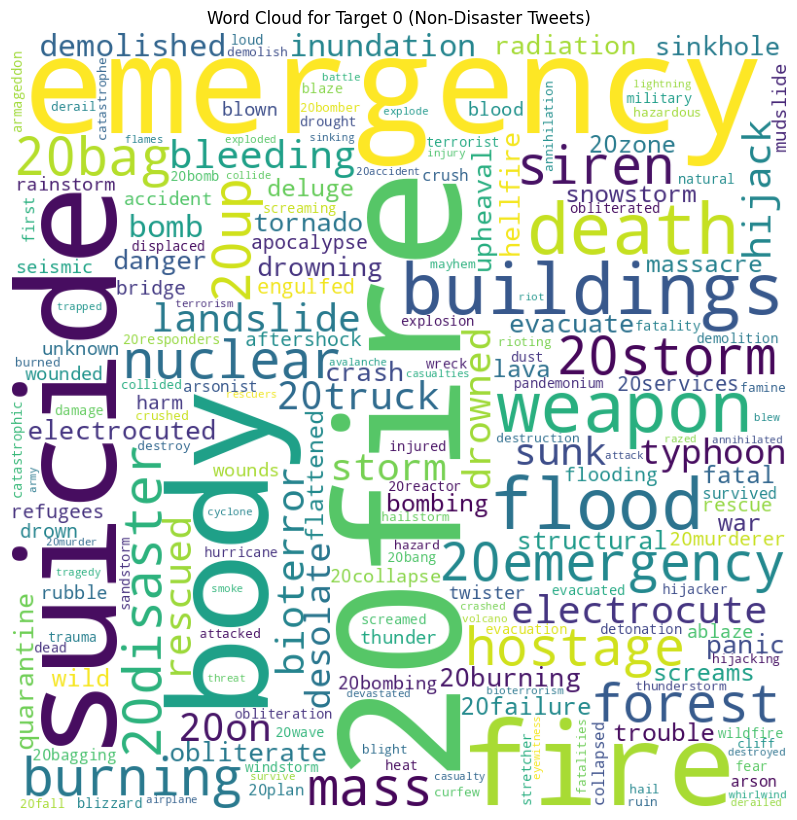

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for tweets with target value 0 (non-disaster)
non_disaster_tweets = train[train['target'] == 0]

# Remove duplicate keywords and generate word cloud for target 0
wordcloud_target_0 = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(set(non_disaster_tweets['keyword'].dropna())))

# Plot word cloud for target 0
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_target_0)
plt.title('Word Cloud for Target 0 (Non-Disaster Tweets)')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [25]:
# Filter the DataFrame for tweets with target value 0 (non-disaster)
non_disaster_tweets = train[train['target'] == 0]

# Count unique keywords for target 0
keyword_counts_target_0 = non_disaster_tweets['keyword'].value_counts()

print("Keyword counts for target 0:")
print(keyword_counts_target_0)


Keyword counts for target 0:
keyword
body%20bags          40
harm                 37
armageddon           37
deluge               36
ruin                 36
                     ..
suicide%20bombing     1
typhoon               1
outbreak              1
suicide%20bomber      1
oil%20spill           1
Name: count, Length: 219, dtype: int64


# 11/ Check Descriptive Statics

In [26]:
description = train['length'].describe(percentiles=[.25, .50, .75])
print(description)

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


# 12/Features Engineering

In [27]:
import numpy as np
import string
from nltk.corpus import stopwords


# Load English stopwords
STOPWORDS = set(stopwords.words('english'))

# Feature engineering

# Word count
train['url_count'] = train['text'].apply(lambda x: len(str(x).split()))

# Word count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

# Unique word count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))

# Stop word count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# URL count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Mean word length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Character count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))

# Punctuation count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Hashtag count
train['hashtag_count'] = train['text'].apply(lambda x: x.count('#'))

# Mention count
train['mention_count'] = train['text'].apply(lambda x: x.count('@'))

# Print the DataFrame to display the changes
print(train.head())


   id  keyword location                                               text  \
0   1  unknown  unknown  Our Deeds are the Reason of this #earthquake M...   
1   4  unknown  unknown             Forest fire near La Ronge Sask. Canada   
2   5  unknown  unknown  All residents asked to 'shelter in place' are ...   
3   6  unknown  unknown  13,000 people receive #wildfires evacuation or...   
4   7  unknown  unknown  Just got sent this photo from Ruby #Alaska as ...   

   target  length  url_count  word_count  unique_word_count  stop_word_count  \
0       1      69          0          13                 13                6   
1       1      38          0           7                  7                0   
2       1     133          0          22                 20               11   
3       1      65          0           8                  8                1   
4       1      88          0          16                 15                7   

   mean_word_length  char_count  punctuation_count

/tmp/ipykernel_18/3557606567.py:16: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', False):  # Suppress warning
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/3557606567.py:16: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', False):  # Suppress warning
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

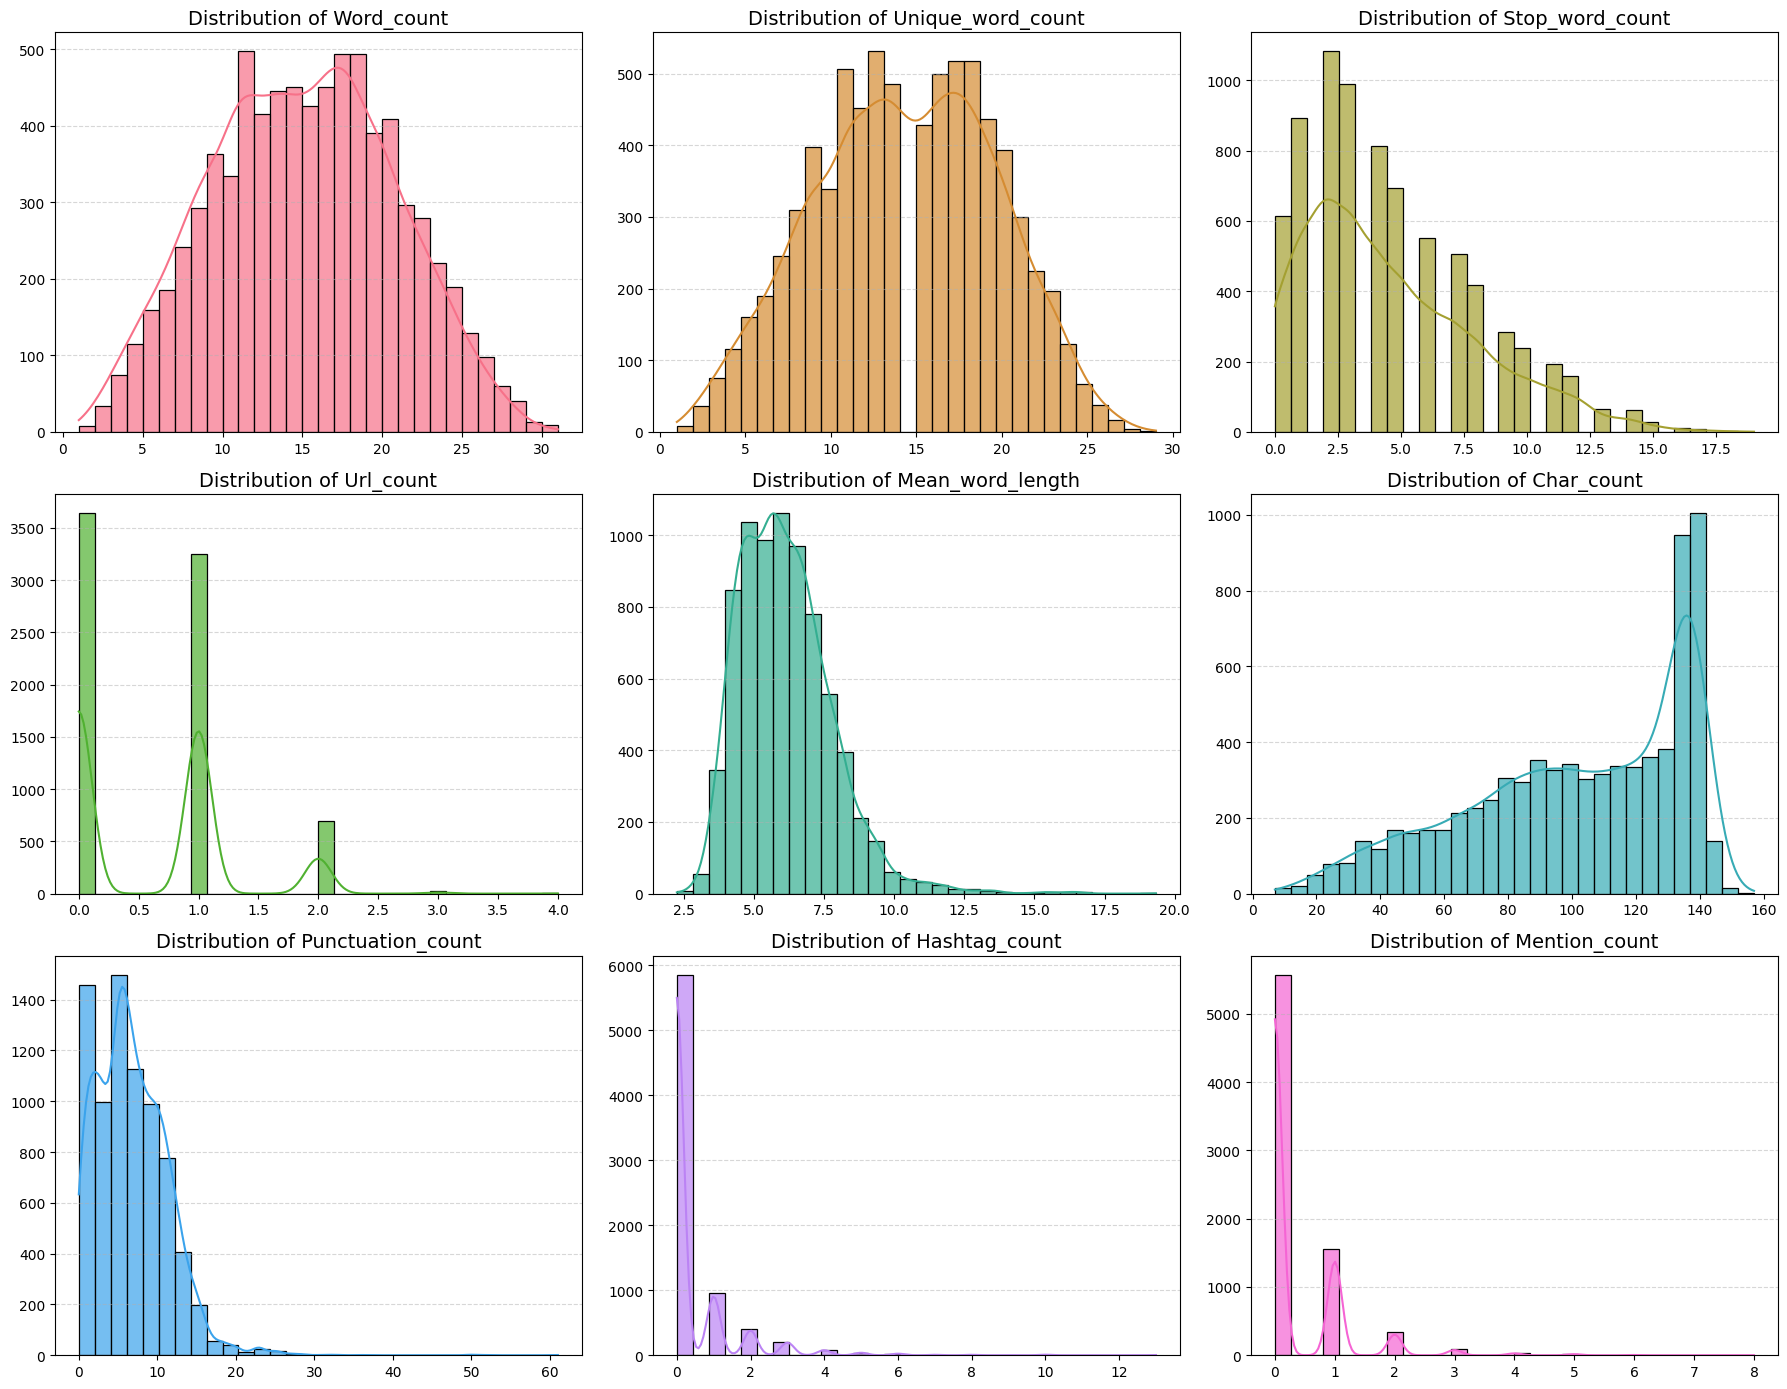

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define features to plot
features_to_plot = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count',
                    'mean_word_length', 'char_count', 'punctuation_count', 
                    'hashtag_count', 'mention_count']

# Define a palette of colors
palette = sns.color_palette("husl", len(features_to_plot))

# Set up the plot grid
plt.figure(figsize=(18, 14))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    with pd.option_context('mode.use_inf_as_na', False):  # Suppress warning
        sns.histplot(train[feature], bins=30, kde=True, color=palette[i-1], alpha=0.7)
    plt.title(f'Distribution of {feature.capitalize()}', fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# 13/Cleaning - Convert to Lower Case

In [29]:
# Showing only
train['text'].apply(lambda x : x.lower())

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @thetawniest the out of control w...
7610    m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [30]:
# Commit to Table
train['text'] = train['text'].apply(lambda x : x.lower())

In [31]:
train.head()

,id,keyword,location,text,target,length,url_count,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,unknown,unknown,our deeds are the reason of this #earthquake m...,1,69,0,13,13,6,4.384615,69,1,1,0
1,4,unknown,unknown,forest fire near la ronge sask. canada,1,38,0,7,7,0,4.571429,38,1,0,0
2,5,unknown,unknown,all residents asked to 'shelter in place' are ...,1,133,0,22,20,11,5.090909,133,3,0,0
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,65,0,8,8,1,7.125000,65,2,1,0
4,7,unknown,unknown,just got sent this photo from ruby #alaska as ...,1,88,0,16,15,7,4.500000,88,2,2,0


In [32]:
columns_to_remove = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count',
                     'mean_word_length', 'char_count', 'punctuation_count',
                     'hashtag_count', 'mention_count']

train.drop(columns=columns_to_remove, inplace=True)
#train.drop(columns=['length'], inplace=True)

In [33]:
train.head()

,id,keyword,location,text,target,length
0,1,unknown,unknown,our deeds are the reason of this #earthquake m...,1,69
1,4,unknown,unknown,forest fire near la ronge sask. canada,1,38
2,5,unknown,unknown,all residents asked to 'shelter in place' are ...,1,133
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,65
4,7,unknown,unknown,just got sent this photo from ruby #alaska as ...,1,88


# Remove Punctuation

In [34]:
#import library and create a for loop for punctuation removal
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [35]:
#remove punctuation check results
train['text'].apply(remove_punctuations)

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [36]:
#remove punctuation check results - commit to table
train['text'] = train['text'].apply(remove_punctuations)

# 14/ Cleaning - Remove Stopwords

In [37]:
# Get Stopwords
stop = stopwords.words('english')

In [38]:
# Concatenate stopwords into a single string
stop_paragraph = ', '.join(stop)

# Print stopwords in a paragraph
print(stop_paragraph)

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

In [39]:
x = "i have a date on sunday with will!!"

In [40]:
[word for word in x.split() if word not in stop]

['date', 'sunday', 'will!!']

In [41]:
# Tokenize and Remove Stop Words
train['text'].apply(lambda x: [word for word in x.split() if word not in stop])

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610    [m194, 0104, utc5km, volcano, hawaii, httptcoz...
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [42]:
train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [43]:
# Join the words back
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [44]:
train.head(10)

,id,keyword,location,text,target,length
0,1,unknown,unknown,deeds reason earthquake may allah forgive us,1,69
1,4,unknown,unknown,forest fire near la ronge sask canada,1,38
2,5,unknown,unknown,residents asked shelter place notified officer...,1,133
3,6,unknown,unknown,13000 people receive wildfires evacuation orde...,1,65
4,7,unknown,unknown,got sent photo ruby alaska smoke wildfires pou...,1,88
5,8,unknown,unknown,rockyfire update california hwy 20 closed dire...,1,110
6,10,unknown,unknown,flood disaster heavy rain causes flash floodin...,1,95
7,13,unknown,unknown,im top hill see fire woods,1,59
8,14,unknown,unknown,theres emergency evacuation happening building...,1,79
9,15,unknown,unknown,im afraid tornado coming area,1,52


# 14/ Cleaning - Lemmatize

In [45]:
nltk.download('wordnet')
nltk.download('wordnet2022')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


True

In [46]:
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

In [47]:
wordnet = WordNetLemmatizer()

In [48]:
# Lemmatize
train['text'].apply(lambda x : wordnet.lemmatize(x))

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [49]:
# Commit to Table
train['text'] = train['text'].apply(lambda x : wordnet.lemmatize(x))

In [50]:
train.head()

,id,keyword,location,text,target,length
0,1,unknown,unknown,deeds reason earthquake may allah forgive us,1,69
1,4,unknown,unknown,forest fire near la ronge sask canada,1,38
2,5,unknown,unknown,residents asked shelter place notified officer...,1,133
3,6,unknown,unknown,13000 people receive wildfires evacuation orde...,1,65
4,7,unknown,unknown,got sent photo ruby alaska smoke wildfires pou...,1,88


# */ Post Pre Cleaning

In [51]:
# Create Length Feature
train['post_text_lenght'] = train['text'].apply(lambda x : len(x))
train.head()

,id,keyword,location,text,target,length,post_text_lenght
0,1,unknown,unknown,deeds reason earthquake may allah forgive us,1,69,44
1,4,unknown,unknown,forest fire near la ronge sask canada,1,38,37
2,5,unknown,unknown,residents asked shelter place notified officer...,1,133,88
3,6,unknown,unknown,13000 people receive wildfires evacuation orde...,1,65,59
4,7,unknown,unknown,got sent photo ruby alaska smoke wildfires pou...,1,88,55


# / Partition

In [52]:
y = train['target']
X = train.drop(columns=['target', 'id'])

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0) # Can you stratify?

In [54]:
# for Proper distributio of Spam and Ham in the train and validation data set we stratified it, to learn the machine propely
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y) # Can you stratify?

# 7/ Preprocessing - Transforming to Numericals  Building  Models
- **CountVectorizer (sklearn.feature_extraction.text)**
- TF-IDF
- ngrams

# 7.1/ CountVectorizer Model

In [55]:
# Import
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
# Create and Intance with max 3000 features
cv = CountVectorizer(max_features=3000)

In [57]:
# Fit 
cv.fit(X_train['text'])

CountVectorizer(max_features=3000)

In [58]:
X_train_cv = cv.transform(X_train['text']).toarray()
X_val_cv = cv.transform(X_val['text']).toarray()

In [59]:
cv.transform(X_train['text']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
train_with_cv = pd.DataFrame(X_train_cv, columns= cv.get_feature_names_out())
train_with_cv.head()

,010401,02,05,06,10,100,1000,101,11,11yearold,...,ûªm,ûªs,ûªt,ûªve,ûïa,ûïthe,ûïwe,ûïwhen,ûò,ûó
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
columns_paragraph = ', '.join(train_with_cv.columns.tolist())
print(columns_paragraph[:1000])


010401, 02, 05, 06, 10, 100, 1000, 101, 11, 11yearold, 12, 12000, 125, 13, 15, 150, 150401, 150foot, 15km, 16, 1620, 166, 16yr, 17, 18, 18w, 19, 1945, 1980, 1st, 20, 2005, 2008, 2011, 2013, 2014, 2015, 2030, 21, 22, 24, 25, 26, 27, 29, 29072015, 2nd, 2pcs, 2pm, 30, 300, 300w, 31, 320, 33, 35, 370, 3g, 3rd, 40, 4000, 45, 48, 4wd, 4x4, 50, 500, 53inch, 5km, 60, 600, 6aug, 70, 70th, 731, 90, 911, 95, 97georgia, aba, abandon, abandoned, abc, abcnews, ability, ablaze, able, absolutely, abstorm, abuse, access, accident, accidentally, accidents, according, account, accused, acres, across, act, action, actions, activated, active, activity, acts, actual, actually, add, added, admits, adult, advance, adventures, advisory, af, affected, afghan, afghanistan, afraid, africa, afterlife, afternoon, aftershock, age, agents, ages, ago, agree, agreed, ah, ahead, aid, aim, aint, air, aircraft, airlines, airplane, airport, aka, al, alabama, alarm, alaska, alberta, album, alcohol, alive, allah, alleged, al

# 8/ PCA

In [62]:
# Import Package
from sklearn.decomposition import PCA

In [63]:
# Create Instance
pca = PCA(n_components=5)

In [64]:
# Fit
pca.fit(X_train_cv)

PCA(n_components=5)

In [65]:
# Transform
X_train_cv = pca.transform(X_train_cv)
X_val_cv = pca.transform(X_val_cv)

In [66]:
X_train_cv

array([[ 0.08538379,  0.12873697, -0.05104259,  0.00681175, -0.3237413 ],
       [-0.0668526 ,  0.00419832, -0.01040526,  0.02246464, -0.04808897],
       [-0.03913283, -0.02222447, -0.04777416,  0.00430299, -0.05612877],
       ...,
       [-0.03912113, -0.06997659, -0.00810307, -0.01524579, -0.04455954],
       [-0.06925115, -0.0007653 , -0.0119807 ,  0.01457766, -0.02292992],
       [-0.05186897,  0.06747325,  0.0313211 ,  0.02159484, -0.07339715]])

# 9/ Build Model Predict

In [67]:
# Import Package
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [68]:
# Create Instance
# nb = MultinomialNB()
lr = LogisticRegression()

In [69]:
# Fit
lr.fit(X_train_cv,y_train)

LogisticRegression()

# 10/ Predict or Train and Validation

In [70]:
# Predict
y_train_pred = lr.predict(X_train_cv)
y_val_pred = lr.predict(X_val_cv)

# 11/ Check Accuracy

In [71]:
print('Train Report ---')
print(classification_report(y_train, y_train_pred))

Train Report ---
              precision    recall  f1-score   support

           0       0.62      0.94      0.75      3473
           1       0.75      0.24      0.36      2617

    accuracy                           0.64      6090
   macro avg       0.69      0.59      0.56      6090
weighted avg       0.68      0.64      0.58      6090



In [72]:
print('Validation Report ---')
print(classification_report(y_val, y_val_pred))

Validation Report ---
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       869
           1       0.79      0.24      0.36       654

    accuracy                           0.65      1523
   macro avg       0.71      0.59      0.56      1523
weighted avg       0.70      0.65      0.59      1523



# Make Prediction on Test Dataset

In [73]:
# import Test data
test = pd.read_csv('/kaggle/input/ipba-17-nlp-with-disaster-tweets-2024/test.csv')

In [74]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [75]:
test.shape

(3263, 4)

In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [77]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [78]:
#replacing missing location values with unknown
test['location'] = test['location'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

In [79]:
#checking missing values
test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [80]:
#After treatment Missing value
test.head()

,id,keyword,location,text
0,0,unknown,unknown,Just happened a terrible car crash
1,2,unknown,unknown,"Heard about #earthquake is different cities, s..."
2,3,unknown,unknown,"there is a forest fire at spot pond, geese are..."
3,9,unknown,unknown,Apocalypse lighting. #Spokane #wildfires
4,11,unknown,unknown,Typhoon Soudelor kills 28 in China and Taiwan


In [81]:
#number of unique values in keyword
test['keyword'].value_counts()

keyword
unknown          26
deluged          23
demolished       22
rubble           22
snowstorm        21
                 ..
threat            5
fatalities        5
forest%20fire     5
inundation        4
epicentre         1
Name: count, Length: 222, dtype: int64

In [82]:
#Cleaning - Convert to Lower Case
test['text'].apply(lambda x : x.lower())
# Commit to Table
test['text'] = test['text'].apply(lambda x : x.lower())

In [83]:
#remove punctuations
test['text'] = test['text'].apply(remove_punctuations)

In [84]:
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

# Get the English stop words
stop = set(stopwords.words('english'))

# Remove stop words from the 'text' column
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop]))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
# Lemmatize
train['text'].apply(lambda x : wordnet.lemmatize(x))
# Commit to Table
train['text'] = test['text'].apply(lambda x : wordnet.lemmatize(x))

In [86]:
test.head()

,id,keyword,location,text
0,0,unknown,unknown,happened terrible car crash
1,2,unknown,unknown,heard earthquake different cities stay safe ev...
2,3,unknown,unknown,forest fire spot pond geese fleeing across str...
3,9,unknown,unknown,apocalypse lighting spokane wildfires
4,11,unknown,unknown,typhoon soudelor kills 28 china taiwan


In [87]:
#create text length feature
test['post_text_lenght'] = test['text'].apply(lambda x : len(x))

In [88]:
# Import
from sklearn.feature_extraction.text import CountVectorizer
# Create and Intance with max 3000 features
cv = CountVectorizer(max_features=3000)
# Fit 
cv.fit(test['text'])
X_test_cv = cv.transform(test['text']).toarray()

In [89]:
# PCA
# Create Instance
pca = PCA(n_components=5)
# Fit
pca.fit(X_test_cv)

# Transform
X_test_cv = pca.transform(X_test_cv)

In [90]:
X_test_cv

array([[-4.18401759e-02, -1.29506788e-03, -5.03410525e-02,
        -9.17352487e-02, -1.38362261e-02],
       [-3.28111812e-02,  1.54195736e-02, -6.73228133e-02,
        -6.33720063e-02,  1.16429164e-01],
       [ 2.33093288e-01, -3.63573545e-02, -1.39803502e-01,
         1.17571637e-01,  5.43823032e-01],
       ...,
       [-3.24482596e-02,  1.41708711e-02, -6.52150637e-02,
        -7.07368727e-02, -3.99198957e-02],
       [-2.59684021e-02,  1.78233069e-02, -6.33505696e-02,
        -8.22890484e-02, -3.98139201e-02],
       [ 3.73487996e-04,  2.07547368e-02, -7.99379071e-02,
        -4.10658793e-02, -9.26216701e-02]])

In [91]:
# Transform the test data using CountVectorizer
X_test_cv = cv.transform(test['text']).toarray()

# Perform PCA on the test data
X_test_pca = pca.transform(X_test_cv)


In [92]:
# Make predictions on the preprocessed test data
y_test_pred = lr.predict(X_test_pca)

In [93]:
y_test_pred


array([0, 0, 0, ..., 0, 0, 0])

In [94]:
# Create a DataFrame for submission
submission_df = pd.DataFrame({'id': test['id'], 'target': y_test_pred})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
